In [3]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

sys.path.append(f"{os.getcwd()}/../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile

import tensorflow as tf
from keras.utils import to_categorical
from keras.initializers import Constant
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, 
    Embedding, Bidirectional, LSTM, GRU, Attention, 
    BatchNormalization, Conv1D, MaxPooling1D, TimeDistributed,
    SpatialDropout1D, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from processing.utils import CleanUp, SNOWBALL_STEMMER, RSLP_STEMMER

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [10]:
clean_up = CleanUp(stemmer=RSLP_STEMMER)

In [11]:
fname = get_tmpfile(f"{os.getcwd()}/../models/w2v.vectors.kv")
w2v = KeyedVectors.load(fname, mmap='r')

In [12]:
max_words = 100_000
batch_size = 128
w2v_size = 300
corpus = []

In [13]:
df = pd.read_csv(f"{os.getcwd()}/../data/frases/dataset_emocoes.csv", sep="|")

In [14]:
X = df["Sentence"].apply(lambda comment: clean_up.fit(str(comment))).to_numpy()
y = pd.get_dummies(df["Emotion"]).to_numpy()

In [15]:
print(f'Dataset size: {len(X)}')

Dataset size: 2496


In [16]:
maxlen = 0
for phrase in X:
    size = len(phrase.split())
    maxlen = size if size > maxlen else maxlen
maxlen += 1
print(f'Maxlen: {maxlen}')

Maxlen: 107


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=False, oov_token='<OOV>', char_level=False)
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

print(f"Vocab size: {vocab_size}")

Vocab size: 5391


In [19]:
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, w2v_size))
for word, i in word_index.items():
    embedding_vector = None
    try:
        embedding_vector = w2v[word]
    except:
        pass
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Embedding Matrix size:', embedding_matrix.shape)

Embedding Matrix size: (5391, 300)


In [20]:
model = Sequential(name='WordEmbeddings')
model.add(
    Embedding(
        len(word_index) + 1,
        w2v_size, 
        weights=[embedding_matrix],
        trainable=True,
    )
)
model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(0.2))
model.add(
    Dense(
        2048,
        activation='elu',
        kernel_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-4)
    )
)
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "WordEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         1617300   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          64128     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2048)              133120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)           

In [21]:
epochs = 20
checkpoint_filepath = './weights.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True)

history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', f'{round(score[1] * 100)}%')

16/16 [==============================] - 0s 7ms/step - loss: 1.4413 - accuracy: 0.5380
Test loss: 1.4413468837738037
Test accuracy: 54%


              precision    recall  f1-score   support

           0       0.54      0.70      0.61       155
           1       0.39      0.19      0.26        63
           2       0.00      0.00      0.00        26
           3       0.80      0.86      0.83        87
           4       0.20      0.03      0.06        29
           5       0.20      0.25      0.22        24
           6       0.48      0.57      0.52       116

    accuracy                           0.54       500
   macro avg       0.37      0.37      0.36       500
weighted avg       0.49      0.54      0.50       500



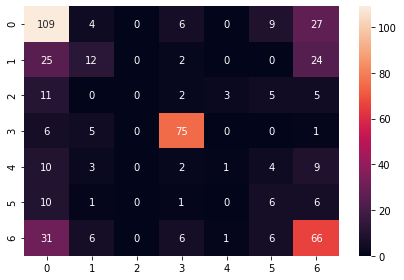

In [22]:
pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(y_test, axis=-1), pred))

df_cm = confusion_matrix(np.argmax(y_test, axis=-1), pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

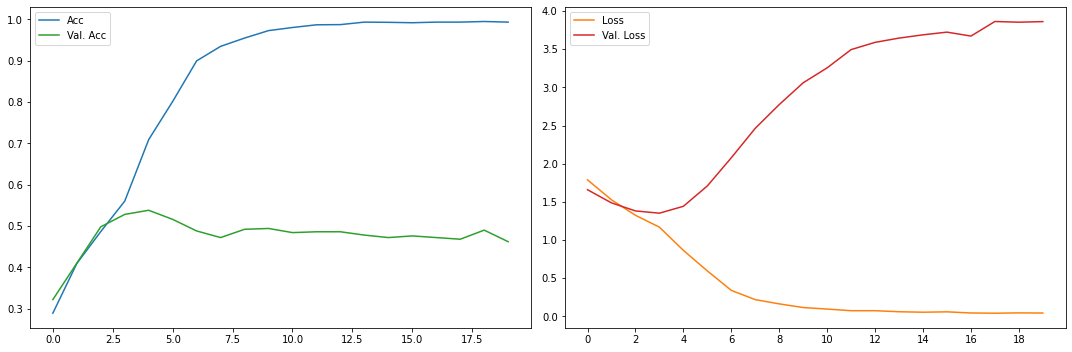

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history["accuracy"], label="Acc", c="C0")
plt.plot(history.history["val_accuracy"], label="Val. Acc", c="C2")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Loss", c="C1")
plt.plot(history.history["val_loss"], label="Val. Loss", c="C3")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()